<a href="https://colab.research.google.com/github/jana0601/Summer_school_archiv-/blob/main/train_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we download and import all neccessary packages

In [ ]:
!git clone --depth=1 https://github.com/ntapiam/dagstuhl.git
%cd dagstuhl

Cloning into 'dagstuhl'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 11 (delta 1), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.
/content/dagstuhl


In [ ]:
import isstorch

from tqdm.notebook import trange
from utils import generate_examples, compute_signatures

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

Set the default `torch` device depending on whether there is a GPU available. We also run a random example to measure speed and check that everything is working OK.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
x = torch.randn(1000, 100, device=device)
with torch.no_grad():
  %time isstorch.compute(x); torch.cuda.synchronize('cuda')
x = x.to('cpu')
with torch.no_grad():
  %time isstorch.compute(x);

KeyboardInterrupt: ignored

We build our model using by subclassing `torch.nn.Module`. We use a stack of dense layers with ReLU activation. To see all possible layers and activations, please see the `torch.nn` [documentation](https://pytorch.org/docs/stable/nn.html).

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, hidden_layers=1, width=10, in_features=3):
        super().__init__()
        self.batch_norm = nn.BatchNorm1d(in_features)
        input_layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=width),
            nn.Tanh()
        )
        layers = [input_layer]
        for k in range(hidden_layers):
            layers.append(nn.Sequential(
                nn.Linear(in_features=width, out_features=width),
                nn.Tanh()
                )
            )
        
        layers.append(
            nn.Sequential(
              nn.Linear(in_features=width, out_features=2),
              nn.LogSoftmax(dim=1)
            )
        )
        self.stack = nn.Sequential(*layers)
    
    def forward(self, x):
        if x.shape[0] > 1:
            x = self.batch_norm(x)
        return self.stack(x)

Next, we set up the training and testing loops

In [ ]:
def train_loop(model, dataloader, loss_fn, optimizer, device):
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_loop(model, dataloader, loss_fn, device):
    total_samples, batches = len(dataloader.dataset), len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(dim=1) == y).type(torch.long).sum().item()
    return correct / total_samples, test_loss / batches

Let's look at some samples. The function `generate_samples` outputs a different set of data each time.

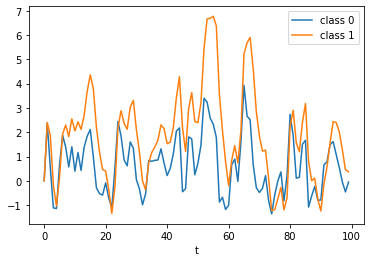

In [ ]:
X, labels = generate_examples()
plt.plot(range(100), X[0], label="class 0")
plt.plot(range(100), X[500], label="class 1")
plt.xlabel('t')
plt.legend()
plt.show()

Now, we compute the signature features using our `pytorch` implementation.

In [ ]:
with torch.no_grad():
  %time sigs = compute_signatures(X, level=4)

print(sigs.shape)
in_features = sigs.shape[1]

CPU times: user 343 ms, sys: 0 ns, total: 343 ms
Wall time: 352 ms
torch.Size([1000, 15])


In order to train and test our Neural Network, we need to wrap the data in a PyTorch `DataLoader`. We also load the data in batches.

In [ ]:
train_sigs, test_sigs, train_labels, test_labels = train_test_split(sigs, labels, stratify=labels, train_size=0.7)
train_dataloader = DataLoader(TensorDataset(train_sigs, train_labels), batch_size=100)
test_dataloader = DataLoader(TensorDataset(test_sigs, test_labels), batch_size=100)

Setup our model, loss function and optimizer. Train the network and output the result.

In [ ]:
%%time
model = DenseNet(hidden_layers=1, width=in_features, in_features=in_features).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = nn.NLLLoss()

epochs = 200
losses = []
accuracies = []
with trange(epochs) as pbar:
    for t in pbar:
        train_loop(model, train_dataloader, loss_fn, optimizer, device)
        acc, avg_loss = test_loop(model, test_dataloader, loss_fn, device)
        losses.append(avg_loss)
        accuracies.append(acc)
        pbar.set_description(f"Training")
        pbar.set_postfix(loss=avg_loss, accuracy=acc)

acc, avg_loss = test_loop(model, test_dataloader, loss_fn, device)
print(f"\nDone! Accuraccy: {acc:.2%}, Loss: {avg_loss:f}")

  0%|          | 0/200 [00:00<?, ?it/s]


Done! Accuraccy: 96.00%, Loss: 0.090666
CPU times: user 3.98 s, sys: 108 ms, total: 4.09 s
Wall time: 4.32 s


Now, we can make a predicition on our test data (or even new inputs), which will be given as a probability distribution over class labels.

Note that we apply the exponential mapping in order to obtain probabilities, as the network outputs negative log probas.

In [ ]:
preds = model(test_sigs[:20].cuda()).exp().cuda()
preds

tensor([[8.4271e-05, 9.9992e-01],
        [3.6225e-04, 9.9964e-01],
        [9.9979e-01, 2.0528e-04],
        [1.8507e-04, 9.9981e-01],
        [9.9807e-01, 1.9299e-03],
        [3.1611e-03, 9.9684e-01],
        [2.8269e-02, 9.7173e-01],
        [5.1718e-05, 9.9995e-01],
        [7.4585e-04, 9.9925e-01],
        [9.9088e-01, 9.1245e-03],
        [1.2287e-04, 9.9988e-01],
        [9.9968e-01, 3.1956e-04],
        [1.1609e-05, 9.9999e-01],
        [8.3181e-01, 1.6819e-01],
        [9.6856e-01, 3.1436e-02],
        [6.0717e-06, 9.9999e-01],
        [9.9776e-01, 2.2374e-03],
        [9.9978e-01, 2.1887e-04],
        [7.7710e-01, 2.2290e-01],
        [9.9848e-01, 1.5189e-03]], device='cuda:0', grad_fn=<ExpBackward>)

We check that they sum to 1 for each example.

In [ ]:
torch.allclose(preds.sum(dim=1), torch.ones(20, device='cuda'))

True

 The predicted label is the one with the highest probability.

In [ ]:
preds.argmax(dim=1), test_labels[:20]

(tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        device='cuda:0'),
 tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0]))

[]

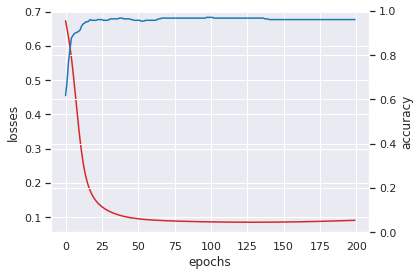

In [ ]:
sns.set_theme()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(epochs), losses, color='tab:red')
ax2.plot(range(epochs), accuracies, color='tab:blue')
ax1.set_xlabel('epochs')
ax1.set_ylabel('losses')
ax2.set_ylim(bottom=0, top=1)
ax2.set_ylabel('accuracy')
fig.tight_layout()
plt.plot()

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(X.flatten(start_dim=1), labels, stratify=labels, train_size=0.7)
train_dataloader = DataLoader(TensorDataset(train_data, train_labels), batch_size=100)
test_dataloader = DataLoader(TensorDataset(test_data, test_labels), batch_size=100)

In [ ]:
%%time
in_features=100
new_model = DenseNet(hidden_layers=1, width=in_features, in_features=in_features).to(device)
new_optimizer = Adam(new_model.parameters(), lr=1e-3)
with trange(epochs) as pbar:
    for t in pbar:
        train_loop(new_model, train_dataloader, loss_fn, new_optimizer, device)
        acc, avg_loss = test_loop(new_model, test_dataloader, loss_fn, device)
        pbar.set_description(f"Training")
        pbar.set_postfix(loss=avg_loss, accuracy=acc)

acc, avg_loss = test_loop(new_model, test_dataloader, loss_fn, device)
print(f"\nDone! Accuraccy: {acc:.2%}, Loss: {avg_loss:f}")

  0%|          | 0/200 [00:00<?, ?it/s]


Done! Accuraccy: 92.67%, Loss: 0.510669
CPU times: user 4.02 s, sys: 132 ms, total: 4.16 s
Wall time: 4.43 s
